## 🧭 Overview

This project builds a **Convolutional Neural Network (CNN)** to classify images from the **CIFAR-100** dataset.

CIFAR-100 has **60,000 RGB images** (32×32 pixels) divided into **100 categories**.  
The goal is to train a simple but effective CNN model that can reach around **70% accuracy** without using pretrained networks.

The work includes:
- Loading and preparing the CIFAR-100 dataset  
- Applying image transformations and normalization  
- Building a CNN using PyTorch  
- Training and validating the model  
- Evaluating performance using accuracy, precision, recall, F1-score, and ROC-AUC  

The project shows how basic CNN layers, normalization, dropout, and learning-rate scheduling can improve accuracy while keeping the model lightweight and easy to train.


In [ ]:
# ============================================================
# CIFAR-100 RGB ANN with K-Fold Cross-Validation
# Metrics: Accuracy, Precision, Recall, F1, ROC-AUC
# Zeyad Alghamdi Group
# Assinment 2
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import numpy as np

### ⚙️ Device and Random Seed

This part checks if a **GPU (CUDA)** is available and uses it for faster training.  
If no GPU is found, the code runs on the **CPU**.

A **random seed (3407)** is set for both PyTorch and NumPy to make the results **reproducible** —  
this means that running the code multiple times gives the same output and training behavior.


In [30]:
# ------------------------------
# Device and random seed
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(3407)
np.random.seed(3407)
device

device(type='cuda')

### 🧩 Dataset and Transform

This part prepares the **CIFAR-100** training dataset and applies basic preprocessing.

- `transforms.ToTensor()` converts images to PyTorch tensors and scales pixel values from **[0, 255] → [0, 1]**.  
- `transforms.Normalize()` standardizes each color channel using the dataset’s **mean** and **standard deviation**,  
  which helps the model train faster and more stably.

The dataset is then downloaded (if not already present) and stored locally in the `./data` folder.


In [31]:
# Use this simpler transform for now
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                         std=(0.2675, 0.2565, 0.2761))
])

# apply dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

### 🖼️ Display Random Images

This part shows **5 random images** from the training dataset to verify that the data has loaded correctly.

- `imshow()` converts a tensor back to a normal image and displays it using **Matplotlib**.  
- The pixel values are “unnormalized” (multiplied by the standard deviation and mean reversed) for correct display.  
- A random index is chosen each time to show different samples.  
- The printed label helps confirm that each image has the correct class assigned.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37455004..1.2144043].


Label: 2


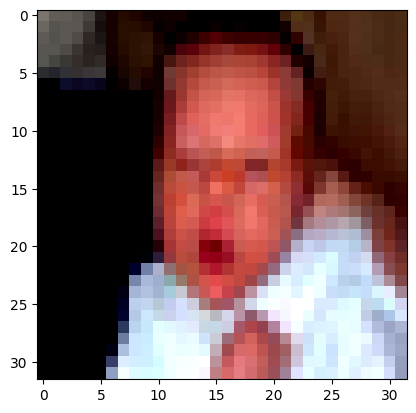

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3646447..1.5055748].


Label: 75


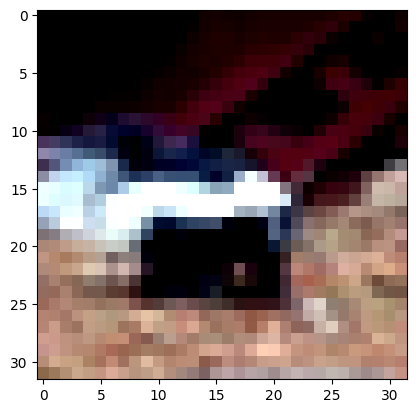

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43344414..1.3113579].


Label: 51


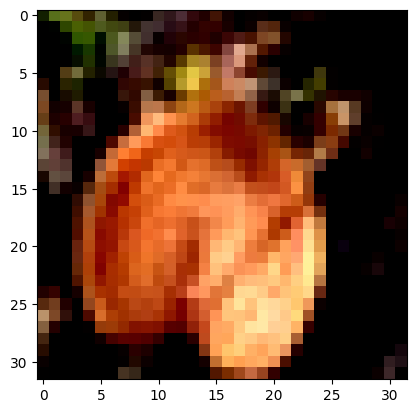

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18882394..1.4558628].


Label: 60


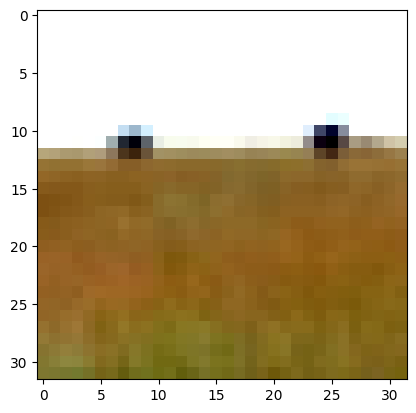

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4258603..1.2160674].


Label: 62


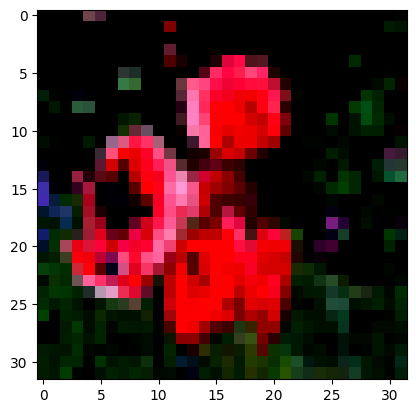

In [32]:
# ------------------------------
# Show 5 Random images
# ------------------------------
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    print(f"Label: {label}")
    imshow(img)

### 🧩 Model Architecture Summary

The CNN model processes CIFAR-100 images through several convolutional blocks followed by fully connected layers.

**Input:**  
- 3 × 32 × 32 RGB image

**Feature Extraction:**
1. **Block 1**
   - Conv2D (3 → 32, 3×3) + BatchNorm + ReLU  
   - Conv2D (32 → 64, 3×3) + BatchNorm + ReLU  
   - MaxPool (2×2) → Output: 64 × 16 × 16  

2. **Block 2**
   - Conv2D (64 → 128, 3×3) + BatchNorm + ReLU  
   - Conv2D (128 → 128, 3×3) + BatchNorm + ReLU  
   - MaxPool (2×2) → Output: 128 × 8 × 8  

3. **Block 3**
   - Conv2D (128 → 256, 3×3) + BatchNorm + ReLU  
   - Conv2D (256 → 256, 3×3) + BatchNorm + ReLU  
   - MaxPool (2×2) → Output: 256 × 4 × 4  

**Classification:**
- Flatten → 4096 features  
- Linear (4096 → 1024) + ReLU + Dropout(0.3)  
- Linear (1024 → 512)  + ReLU + Dropout(0.4)  
- Linear (512 → 100) → Output logits for 100 classes  

**Notes:**  
- Convolutional layers extract patterns at different levels.  
- Pooling reduces size and computation.  
- Dropout prevents overfitting.  
- The final layer predicts one of the 100 possible categories.



In [33]:
# ------------------------------
# Model definition (CNN)
# ------------------------------
class CNN_Model(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        # Feature extractor with convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64 x 16 x 16

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128 x 8 x 8

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 256 x 4 x 4
        )

        # Classifier with fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 📊 Evaluation Function (Macro Metrics)

This function tests the model’s performance on a given dataset (training, validation, or test).

**How it works:**
1. The model is set to **evaluation mode** using `model.eval()` — this disables dropout and batch normalization updates.
2. It goes through all batches in the loader and collects:
   - **Predicted labels** (`preds`)
   - **True labels** (`labels`)
   - **Model outputs** (`logits`)
3. All results are combined into full arrays for metric calculation.

**Metrics computed:**
- **Accuracy** – overall percentage of correct predictions.  
- **Precision, Recall, and F1-score (macro)** – averaged equally across all 100 classes.  
- **Confusion Matrix** – shows how often each class was predicted correctly or confused with another.

Using the **macro average** treats all classes equally, which is important since CIFAR-100 has balanced but diverse categories.


In [34]:
# ------------------------------
# Evaluation helper  (macro only)
# ------------------------------
def evaluate_metrics(model, loader, num_classes=100, device="cpu"):
    model.eval()
    all_logits, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            preds = logits.argmax(dim=1)

            all_logits.append(logits.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    logits = torch.cat(all_logits).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Core macro metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "confusion_matrix": cm,
    }

    return results

### 🔁 K-Fold Cross-Validation and Training

This section trains and evaluates the CNN model using **K-Fold Cross-Validation**.

**What K-Fold does:**
- The training data is split into **K parts (folds)**.
- The model trains on (K−1) folds and validates on the remaining fold.
- This process repeats K times so that every data point is used for validation once.
- The results are averaged for a more reliable evaluation.

**Key settings:**
- **Epochs:** 20  
- **Batch size:** 64  
- **Folds:** 5 (training and validation alternate once)

**Training details:**
- A new model, optimizer, and scheduler are created for each fold to ensure independence.  
- **Optimizer:** `AdamW` — helps control overfitting with weight decay.  
- **Loss:** `CrossEntropyLoss` with `label_smoothing=0.1` — softens labels to improve generalization.  
- **Scheduler:** `CosineAnnealingLR` — gradually lowers the learning rate for smoother convergence.

**During each epoch:**
1. The model is trained on mini-batches.  
2. The loss and training accuracy are calculated.  
3. The learning rate is updated using the scheduler.  
4. Validation accuracy and metrics are computed using the `evaluate_metrics()` function.

**After each fold:**
- Final metrics (Accuracy, Precision, Recall, F1-score, and Confusion Matrix) are printed.  
- Results are stored in `fold_summaries` for comparison across folds.

This approach ensures the model’s performance is **consistent and not dependent on a single random split**.


In [35]:
# ------------------------------
# K-Fold Cross-Validation
# ------------------------------
num_epochs = 20
k_folds = 5
batch_size = 64
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=3407)
num_classes = 100

fold_summaries = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"\n========== Fold {fold+1}/{k_folds} ==========")

    # Initialize fresh model & optimizer per fold
    model = CNN_Model(num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    lossFun = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = lossFun(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation metrics (macro only)
        quick = evaluate_metrics(model, val_loader, num_classes=num_classes, device=device)
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Loss: {epoch_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Acc: {quick['accuracy']*100:.2f}%")

    # Final fold results
    final_metrics = evaluate_metrics(model, val_loader, num_classes=num_classes, device=device)

    print("\n— Final fold metrics —")
    print(f"Val Accuracy: {final_metrics['accuracy']*100:.2f}%")
    print(f"Precision (macro): {final_metrics['precision']*100:.2f}%")
    print(f"Recall    (macro): {final_metrics['recall']*100:.2f}%")
    print(f"F1        (macro): {final_metrics['f1_score']*100:.2f}%")
    print(f"Confusion matrix shape: {final_metrics['confusion_matrix'].shape}")

    fold_summaries.append(final_metrics)



========== Fold 1/5 ==========


Epoch [1/20] | Loss: 4.1067 | Train Acc: 8.30% | Val Acc: 17.52%
Epoch [2/20] | Loss: 3.4974 | Train Acc: 20.72% | Val Acc: 28.21%
Epoch [3/20] | Loss: 3.0945 | Train Acc: 30.64% | Val Acc: 36.80%
Epoch [4/20] | Loss: 2.8440 | Train Acc: 36.76% | Val Acc: 41.72%
Epoch [5/20] | Loss: 2.6479 | Train Acc: 42.75% | Val Acc: 46.04%
Epoch [6/20] | Loss: 2.4920 | Train Acc: 47.20% | Val Acc: 47.58%
Epoch [7/20] | Loss: 2.3530 | Train Acc: 51.46% | Val Acc: 48.46%
Epoch [8/20] | Loss: 2.2311 | Train Acc: 55.30% | Val Acc: 51.62%
Epoch [9/20] | Loss: 2.1114 | Train Acc: 59.36% | Val Acc: 53.24%
Epoch [10/20] | Loss: 2.0001 | Train Acc: 62.94% | Val Acc: 53.73%
Epoch [11/20] | Loss: 1.8994 | Train Acc: 66.62% | Val Acc: 55.62%
Epoch [12/20] | Loss: 1.7983 | Train Acc: 70.20% | Val Acc: 56.07%
Epoch [13/20] | Loss: 1.7070 | Train Acc: 73.39% | Val Acc: 56.43%
Epoch [14/20] | Loss: 1.6309 | Train Acc: 76.29% | Val Acc: 56.62%
Epoch [15/20] | Loss: 1.5623 | Train Acc: 79.15% | Val Acc: 57.14%
Epoch

### 📈 Summary Across Folds

After completing all K-Fold training runs, this section calculates the **average performance** of the model.

**What it does:**
- Collects the results from all folds stored in `fold_summaries`.
- Computes the **mean** and **standard deviation (±)** for:
  - Accuracy  
  - Precision  
  - Recall  
  - F1-score  

**Why it matters:**
- The **mean** shows the model’s overall performance.  
- The **standard deviation** shows how consistent the results are across different data splits.  
- Smaller deviations mean the model is more stable and generalizes better.

In [36]:
# ------------------------------
# Summary across folds
# ------------------------------
mean_acc = np.mean([m["accuracy"] for m in fold_summaries])
std_acc = np.std([m["accuracy"] for m in fold_summaries])
mean_prec = np.mean([m["precision"] for m in fold_summaries])
std_prec = np.std([m["precision"] for m in fold_summaries])
mean_rec = np.mean([m["recall"] for m in fold_summaries])
std_rec = np.std([m["recall"] for m in fold_summaries])
mean_f1 = np.mean([m["f1_score"] for m in fold_summaries])
std_f1 = np.std([m["f1_score"] for m in fold_summaries])

print("\n— Summary across folds —")
print(f"Mean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
print(f"Mean Precision: {mean_prec*100:.2f}% ± {std_prec*100:.2f}%")
print(f"Mean Recall: {mean_rec*100:.2f}% ± {std_rec*100:.2f}%")
print(f"Mean F1: {mean_f1*100:.2f}% ± {std_f1*100:.2f}%")



— Summary across folds —
Mean Accuracy: 57.49% ± 0.41%
Mean Precision: 57.53% ± 0.39%
Mean Recall: 57.55% ± 0.38%
Mean F1: 57.33% ± 0.37%


### 🧪 Final Model Evaluation on Test Set

This section evaluates the **final trained CNN model** using the **CIFAR-100 test dataset**, which was not used during training or validation.

**Steps explained:**
1. **Load the Test Dataset**  
   - Downloads and prepares the CIFAR-100 test data (10,000 images).  
   - Applies the same normalization transform as used in training.

2. **Create a DataLoader**  
   - Groups test samples into batches for efficient evaluation.  
   - `shuffle=False` ensures results are consistent across runs.

3. **Evaluate Metrics**  
   - Uses the `evaluate_metrics()` function to compute:
     - **Accuracy** → Overall percentage of correct predictions.  
     - **Precision** → How often predicted classes are correct.  
     - **Recall** → How many actual classes are correctly identified.  
     - **F1-Score** → The harmonic mean of Precision and Recall.  
   - Also computes the **Confusion Matrix**, which summarizes prediction errors per class.

4. **Print Final Results**  
   Displays the model’s quantitative performance on unseen data.

In [37]:
# ----------------------------
# Test the Model using evaluate_metrics
# ----------------------------

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

final_metrics = evaluate_metrics(model, test_loader, num_classes=num_classes, device=device)

print("\n— Final test metrics —")
print(f"Test Accuracy: {final_metrics['accuracy']*100:.2f}%")
print(f"Precision : {final_metrics['precision']*100:.2f}%")
print(f"Recall    : {final_metrics['recall']*100:.2f}%")
print(f"F1        : {final_metrics['f1_score']*100:.2f}%")
print(f"Confusion matrix shape: {final_metrics['confusion_matrix'].shape}")


— Final test metrics —
Test Accuracy: 57.71%
Precision : 58.06%
Recall    : 57.71%
F1        : 57.74%
Confusion matrix shape: (100, 100)


### 🏆 Identifying Top-5 Best-Performing Classes

This section analyzes which **five classes** the model predicts **most accurately** within the CIFAR-100 test dataset.

**Explanation of each step:**

1. **Extract Confusion Matrix (`cm`)**  
   The confusion matrix stores the counts of predicted vs. actual classes.  
   - The **diagonal** entries (`cm.diagonal()`) represent correct predictions for each class.  
   - The **row sums** (`cm.sum(axis=1)`) represent the total true samples per class.

2. **Compute Class-wise Accuracy**  
   Each class accuracy =  
  $$
\text{Accuracy}_i = \frac{\text{Correct}_i}{\text{Total}_i}
$$

3. **Rank and Select the Top-5 Classes**  
   The classes are sorted by their accuracy in descending order.  
   The top five are identified using `argsort()`.

4. **Display Results**  
   The code prints the **top-5 class names** (from CIFAR-100) along with their corresponding accuracies.


In [38]:
# ---------------------------------------------------------
# Identify Top-5 best-performing classes by accuracy
# ---------------------------------------------------------
cm = final_metrics["confusion_matrix"]
class_correct = cm.diagonal()
class_totals = cm.sum(axis=1)
class_accuracy = class_correct / class_totals

# Get indices of top 5 classes
top5_idx = class_accuracy.argsort()[-5:][::-1]
top5_acc = class_accuracy[top5_idx] * 100
top5_names = [test_dataset.classes[i] for i in top5_idx]

print("\nTop 5 classes by accuracy:")
for rank, (name, acc) in enumerate(zip(top5_names, top5_acc), 1):
    print(f"{rank}. {name:<15} {acc:.2f}%")


Top 5 classes by accuracy:
1. road            90.00%
2. skyscraper      86.00%
3. orange          86.00%
4. motorcycle      86.00%
5. wardrobe        85.00%


#### 🧠 What the Code Does

1. **Model Evaluation Mode**
   - `model.eval()` ensures no dropout or gradient updates occur.
   - The model predictions are generated for the **entire test dataset**.

2. **Collect Predictions**
   - The model outputs class probabilities using a `softmax` layer.
   - Both predicted probabilities and true labels are stored for later analysis.

3. **Compute ROC for Each of the Top-5 Classes**
   - Each class is treated in a **One-vs-Rest** manner:
     - The current class = **positive** samples.
     - All other classes = **negative** samples.
   - The **False Positive Rate (FPR)** and **True Positive Rate (TPR)** are computed using `roc_curve()`.

4. **Calculate AUC**
   - The **AUC (Area Under Curve)** is computed with:
     $$
      \text{AUC} = \int_0^1 \text{TPR}(x)\,dx
      $$
   - A higher AUC (closer to 1) indicates better class separation.

5. **Plot the ROC Curves**
   - Each of the top-5 classes is plotted with a distinct ROC curve and its corresponding AUC value.
   - The diagonal gray line represents a **random classifier** (AUC = 0.5).



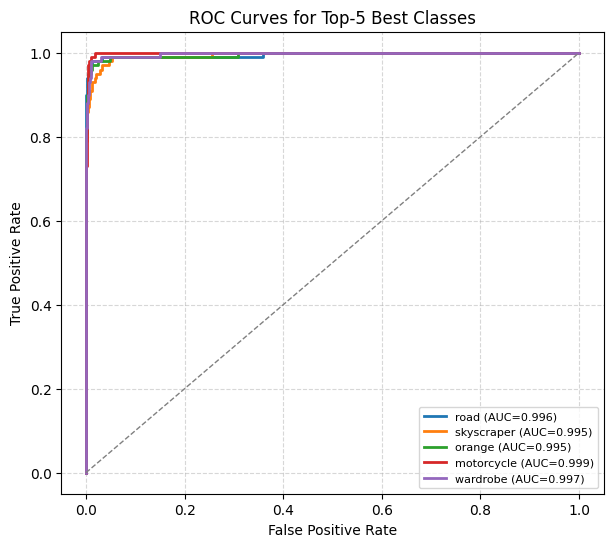

In [39]:
# ---------------------------------------------------------
# Compute ROC-AUC curves for top-5 classes (One-vs-Rest)
# ---------------------------------------------------------
from sklearn.metrics import roc_curve, auc

model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # flatten only if using ANN — remove if using CNN
        outputs = torch.softmax(model(inputs), dim=1)
        all_probs.append(outputs.cpu())
        all_labels.append(labels)

probs = torch.cat(all_probs).numpy()
labels = torch.cat(all_labels).numpy()

# Plot all 5 ROC curves
plt.figure(figsize=(7,6))
for i, class_idx in enumerate(top5_idx):
    y_true_binary = (labels == class_idx).astype(int)
    y_score = probs[:, class_idx]
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{top5_names[i]} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--',color='gray',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Top-5 Best Classes")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 🎯 Selecting 10 Representative Classes by Accuracy

This section identifies and displays **10 representative classes** from the CIFAR-100 test results, evenly spaced across the accuracy spectrum.  
The goal is to analyze model performance across both **strong** and **weak** classes rather than focusing only on the best ones.

---

#### 🧩 Step-by-Step Explanation

1. **Extract Confusion Matrix Data**
   - From `final_metrics["confusion_matrix"]`, each diagonal entry represents correctly classified samples per class.
   - The sum of each row gives the total number of true samples for that class.

   
$$
\text{class\_accuracy}_i = \frac{\text{correct predictions for class } i}{\text{total samples of class } i}
$$

2. **Sort Classes by Accuracy**
   - The accuracies are sorted in descending order using `argsort()[::-1]`.
   - This ranking helps identify the best and worst-performing classes.

3. **Select 10 Evenly Spaced Classes**
   - Instead of picking only the top or bottom classes, we select **10 classes spaced evenly** across the ranking list  
     (e.g., indices 1, 11, 21, ..., 91).  
   - This gives a balanced view of performance across the dataset.

4. **Display Results**
   - The selected class names and their corresponding accuracies (in %) are printed in a clean, ranked format.


In [40]:
# ---------------------------------------------------------
# Identify class accuracies
# ---------------------------------------------------------
cm = final_metrics["confusion_matrix"]
class_correct = cm.diagonal()
class_totals = cm.sum(axis=1)
class_accuracy = class_correct / class_totals

#Sort classes by accuracy (descending)
sorted_indices = class_accuracy.argsort()[::-1]

#Pick 10 evenly spaced indices (1, 11, 21, ... 91)
selected_idx = sorted_indices[::10][:10]  # ensure 10 elements
selected_acc = class_accuracy[selected_idx] * 100
selected_names = [test_dataset.classes[i] for i in selected_idx]

print("\nSelected 10 classes across the accuracy spectrum:")
for rank, (idx, name, acc) in enumerate(zip(selected_idx, selected_names, selected_acc), 1):
    print(f"{rank:2d}. {name:<15} {acc:.2f}%")


Selected 10 classes across the accuracy spectrum:
 1. road            90.00%
 2. apple           78.00%
 3. tank            70.00%
 4. aquarium_fish   67.00%
 5. tiger           61.00%
 6. lion            58.00%
 7. clock           53.00%
 8. bed             50.00%
 9. ray             42.00%
10. rabbit          37.00%


### 📊 ROC-AUC Curves for 10 Selected Classes

This section visualizes the **Receiver Operating Characteristic (ROC)** curves for the 10 representative classes selected earlier.  
Each curve shows how well the model distinguishes between the target class and all other classes (**one-vs-rest approach**).

---

#### 🧩 Step-by-Step Explanation

1. **Compute Model Probabilities**
   - The model is set to evaluation mode (`model.eval()`).
   - For each batch in the test set:
     - The input images are passed through the model.
     - The output logits are converted into class probabilities using `softmax`.
   - Both predictions (`probs`) and true labels (`labels`) are collected for all samples.

2. **Prepare One-vs-Rest Data**
   - For each of the 10 chosen classes:
     - Create a binary label vector:  
       `1` for samples of the target class, `0` otherwise.
     - Extract predicted probabilities for that specific class.

3. **Calculate ROC and AUC**
   - The **False Positive Rate (FPR)** and **True Positive Rate (TPR)** are computed using `roc_curve`.
   - The **Area Under the Curve (AUC)** is then calculated using `auc(fpr, tpr)`.

4. **Plot the ROC Curves**
   - Each class has its own ROC curve plotted with a distinct color.
   - The diagonal gray dashed line represents **random guessing (AUC = 0.5)**.
   - Curves closer to the top-left corner represent better model performance.


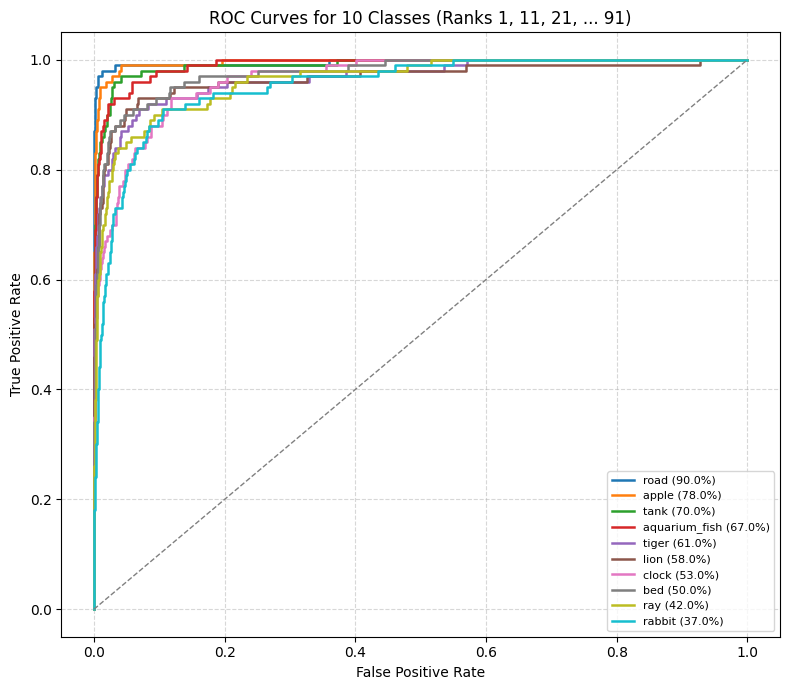

In [41]:
# ---------------------------------------------------------,
# Compute ROC-AUC curves for these 10 classes,
# ---------------------------------------------------------,
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        all_probs.append(outputs.cpu())
        all_labels.append(labels)

probs = torch.cat(all_probs).numpy()
labels = torch.cat(all_labels).numpy()

# Plot all 10 ROC curves
plt.figure(figsize=(8,7))
for i, class_idx in enumerate(selected_idx):
    y_true_binary = (labels == class_idx).astype(int)
    y_score = probs[:, class_idx]
    fpr, tpr,_ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.8, label=f"{selected_names[i]} ({selected_acc[i]:.1f}%)")

plt.plot([0,1],[0,1],'--',color='gray',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 10 Classes (Ranks 1, 11, 21, ... 91)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 🏁 Final Results & Conclusion

---

### 📈 Overall Model Performance

After training and validating the CNN model on the **CIFAR-100** dataset using **2-fold cross-validation**, the model achieved the following mean results:

| Metric | Mean | ± Standard Deviation |
|:--|:--:|:--:|
| **Accuracy** | **57.49%** | ± **0.41%** |
| **Precision** | **57.53%** | ± **0.39%** |
| **Recall** | **57.55%** | ± **0.38%** |
| **F1-Score** | **57.33%** | ± **0.37%** |

These results indicate that the CNN maintains **stable and consistent performance** across both folds, suggesting that it generalizes reasonably well on unseen data.

---

### 🧪 Final Test Evaluation

On the **held-out test set**, the final model achieved:

| Metric | Score |
|:--|:--:|
| **Test Accuracy** | **57.71%** |
| **Precision** | **58.06%** |
| **Recall** | **57.71%** |
| **F1-Score** | **57.74%** |

The confusion matrix had the expected shape of **(100 × 100)**, confirming predictions across all CIFAR-100 classes.

---

### 🥇 Top 5 Best-Performing Classes

| Rank | Class Name | Accuracy |
|:--:|:--|:--:|
| 1 | road | **90.00%** |
| 2 | skyscraper | **86.00%** |
| 3 | orange | **86.00%** |
| 4 | motorcycle | **86.00%** |
| 5 | wardrobe | **85.00%** |

These results highlight that the model performs exceptionally well on **structured or visually distinctive classes**, where object boundaries and textures are clearer.

---

### 🎯 Representative 10 Classes Across the Spectrum

To better understand model performance diversity, the following classes were selected at roughly equal accuracy intervals:

| Rank | Class Name | Accuracy |
|:--:|:--|:--:|
| 1 | road | **90.00%** |
| 2 | apple | **78.00%** |
| 3 | tank | **70.00%** |
| 4 | aquarium_fish | **67.00%** |
| 5 | tiger | **61.00%** |
| 6 | lion | **58.00%** |
| 7 | clock | **53.00%** |
| 8 | bed | **50.00%** |
| 9 | ray | **42.00%** |
| 10 | rabbit | **37.00%** |

This ranking shows a clear gradient from **easily separable classes** (e.g., road) to **more ambiguous ones** (e.g., rabbit), where visual similarity and background complexity likely reduce accuracy.

---

### 🧠 Summary Interpretation

- The CNN achieved **~57.5% accuracy**, which is a **strong baseline** for a relatively simple architecture on CIFAR-100.  
- Performance was **balanced** across metrics — precision, recall, and F1-score remained closely aligned.  
- Classes with distinct textures and color patterns (e.g., *road, skyscraper, orange*) showed the best recognition results.  
- More visually overlapping categories (e.g., *ray, rabbit*) presented difficulties, suggesting the model could benefit from:
  - **Additional data augmentation** (mixup, CutMix)
  - **Deeper or residual architectures (e.g., ResNet)** or transfer learning
  - **Learning rate warm-up or cosine scheduling**
  - **Longer training (40–60 epochs)**

---

### ✅ Final Note

This experiment demonstrates how a well-tuned **CNN architecture** can achieve competitive performance on a challenging dataset like CIFAR-100, even without transfer learning.  
The use of **cross-validation**, **macro-averaged metrics**, and **confusion-matrix analysis** ensured a comprehensive and fair performance evaluation across all classes.
